# Chapter 5: The Many Variables & The Spurious Waffles

In [1]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata
from theano import shared

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0)

Waffle House and divorce rate correlation

In [3]:
# Load data
data = pd.read_csv(os.path.join("Data", "WaffleDivorce.csv"), delimiter=";")

In [4]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [5]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

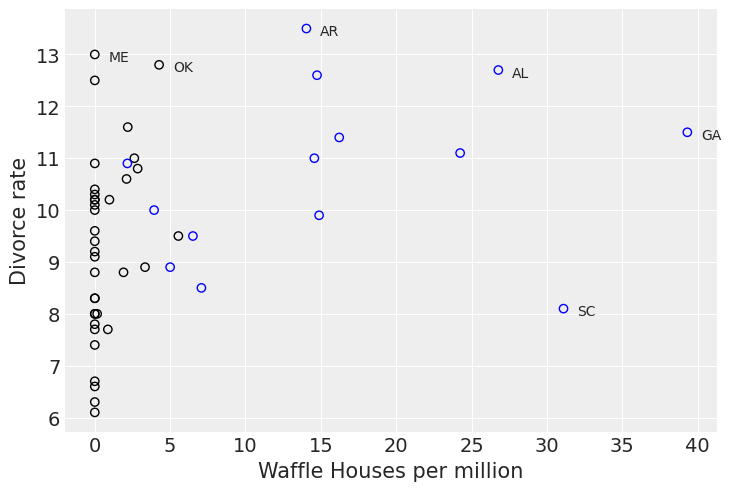

In [6]:
# Fig 5.1, missing mean
fig, ax = plt.subplots()

# assign colours to confederate states
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WaffleHouses"] / data["Population"],
    data["Divorce"],
    lw=1,
    color=(0, 0, 0, 0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")

# take only the states with Divorce rate over 12.6 or number of Waffle houses per million inhabitants over 30
selection = data[(data["Divorce"] > 12.6) | (data["WaffleHouses"] / data["Population"] > 30)]

# label those points
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5))

**Multiple regression** is useful to distinguish association from causation because *more than one predictor values are used*. More specifically, the reasons given for multiple regression models include:
1. Statistical "control" for confounds
2. Multiple & complex causation
3. Interactions

This chapter, we talk about multipl regression w/ main effects w/ the Gaussian mean. Heads-up:
- Categorical variables need special treatment.
- We will think about causal inference.

***RETHINKING: Causal inference***
- There's *no unified approach* to causal inference yet in the sciences.
- **Causal inference always depends on unverifiable assumptions**

## 5.1. Spurious association

Text(0.5, 0, 'Median age marriage')

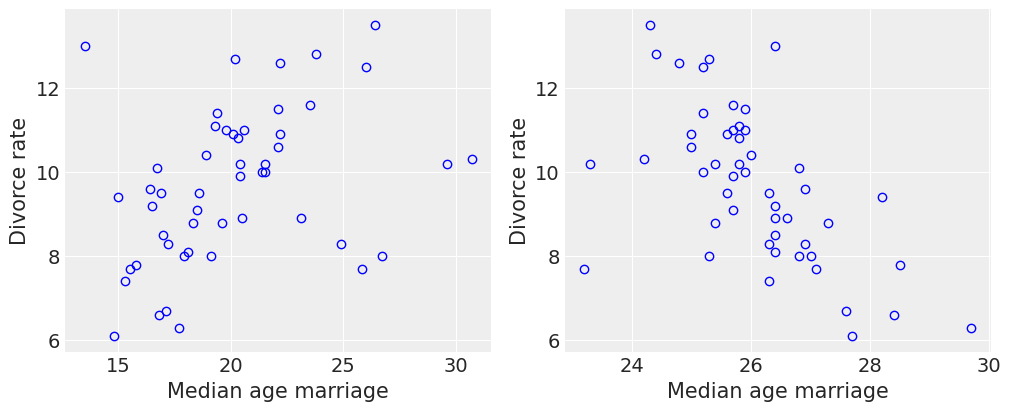

In [7]:
# Fig 5.2, missing mean and CI
fid, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(data["Marriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[0].set_ylabel("Divorce rate")
ax[0].set_xlabel("Median age marriage")

ax[1].scatter(data["MedianAgeMarriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[1].set_ylabel("Divorce rate")
ax[1].set_xlabel("Median age marriage")

##### 5.1

In [8]:
# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

##### 5.2

Divorce rate model: we can consider two factors; marriage rate and median age marriage

Bayesian model for the model that uses **median age marriage** as a predictor:
$$D_{i} \sim \text{Normal}(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha + \beta_{A}A_{i}$$
$$\alpha \sim \text{Normal}(0, 0.2)$$
$$\beta_{A} \sim \text{Normal}(0, 0.5)$$
$$\sigma \sim \text{Exponential}(1)$$

**Priors**
- $\alpha$: since x and y are both standardized, intercept should be near 0.
- $\beta_{A}$
    - **Check the meaning first**: if $\beta_{A}=1$, **a change of 1 SD of age at marriage is associated w/ a change of 1 SD in divorce rate**.
    - Now, calculate the SD of age at marriage:

In [9]:
data["MedianAgeMarriage"].std()

1.2436303013880823

This means, when $\beta_{A}=1$, a change of 1.2 years in median age at marraige is associated with a full SD change in the outcome (which is a lot!). The above prior assumes that **only 5% of plausible sploes are more extreme than 1**.

Approximating the posterior: (we're also sampling prior too)

##### 5.3

In [10]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


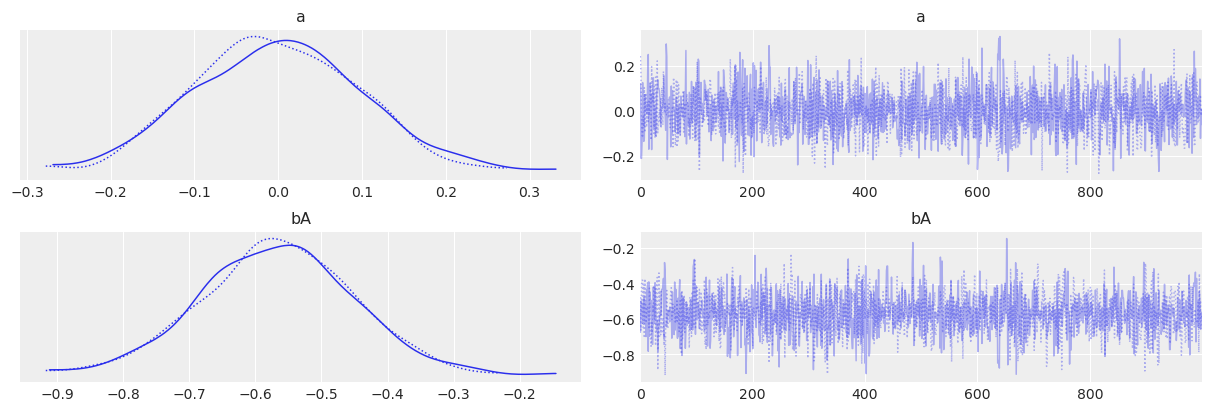

In [11]:
az.plot_trace(m_5_1_trace, var_names=["a", "bA"]);

Plotting the priors

##### 5.4

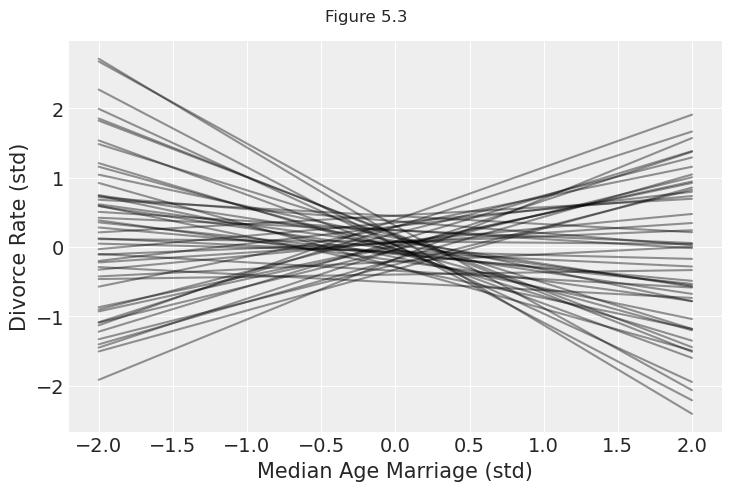

In [12]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50) # standardized median age marriage

for a, ba in zip(prior_samples["a"][:50], prior_samples["bA"][:50]):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");

Posterior predictions: $\mu_{i}$

##### 5.5

In [13]:
m_5_1_trace["bA"].shape, m_5_1_trace["a"].shape, len(m_5_1_trace)

((2000,), (2000,), 1000)

In [14]:
# This is equivalent of link function

age_std_seq = np.linspace(-3, 3.2, 30) # slightly wider x axis range

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
mu_pred = np.zeros((len(age_std_seq), len(m_5_1_trace) * m_5_1_trace.nchains)) # there are 2 chains (initializing)

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_1_trace["a"] + m_5_1_trace["bA"] * age_std

In [15]:
mu_pred.shape

(30, 2000)

Again, for `az.plot_hdi`, check the dimension:

In [16]:
age_std_seq.shape, mu_pred.T.shape

((30,), (2000, 30))

Plotting the PI

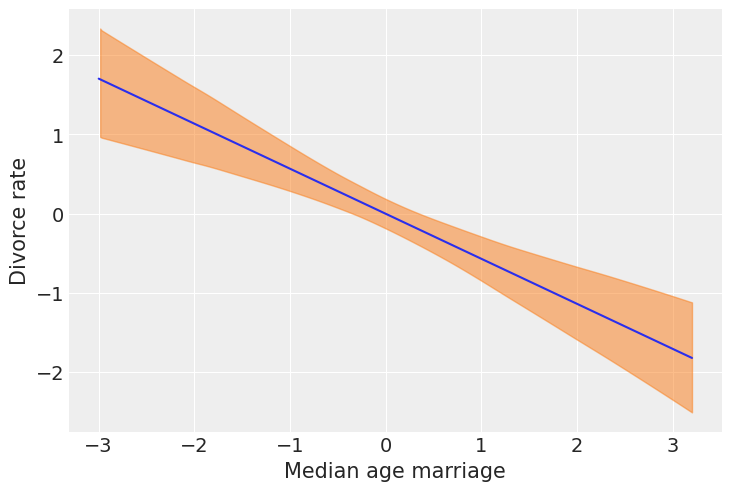

In [17]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred.mean(axis=1)

# This is equivalent of Percent Interval
ax = az.plot_hdi(age_std_seq, mu_pred.T)
plt.plot(age_std_seq, mu_mean)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate");

Similar exercise for the marriage rate and divorce rate model (one predictor)

##### 5.6

In [18]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"])

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


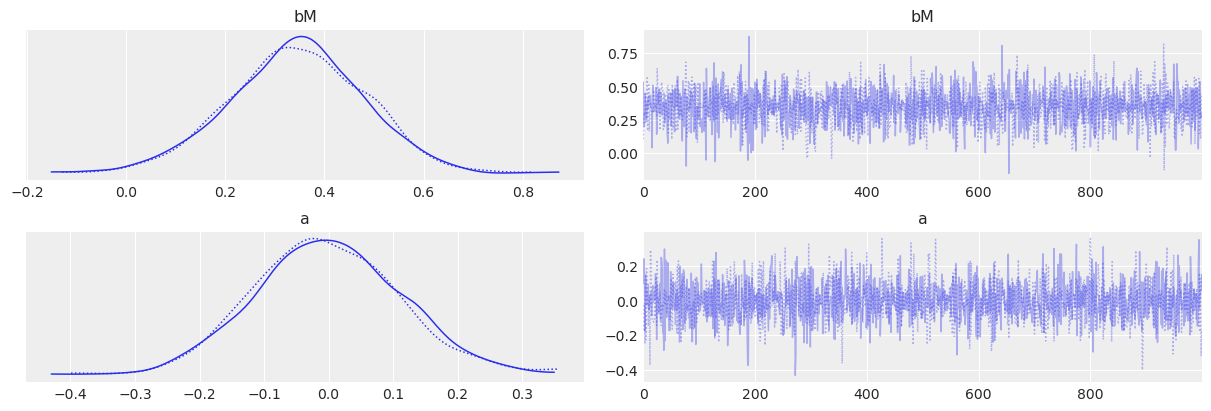

In [19]:
az.plot_trace(m_5_2_trace, var_names=["bM", "a"]);

In [20]:
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
mu_pred = np.zeros((len(age_std_seq), len(m_5_2_trace) * m_5_2_trace.nchains)) # there are 2 chains (initializing)
for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_2_trace["a"] + m_5_2_trace["bM"] * age_std

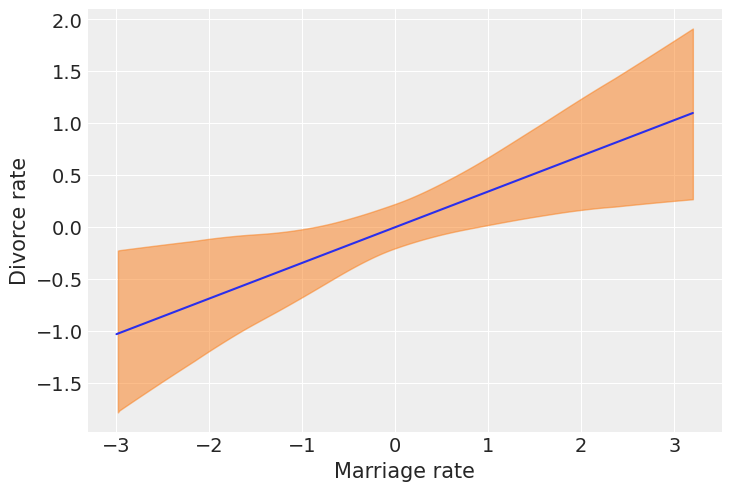

In [21]:
mu_mean = mu_pred.mean(axis=1)
ax = az.plot_hdi(age_std_seq, mu_pred.T)
plt.plot(age_std_seq, mu_mean)
ax.set_xlabel("Marriage rate")
ax.set_ylabel("Divorce rate");

### 5.1.1. Think before you regress.

Three observed variables
- Divorce rate (D)
- Marriate rate (M)
- Median age at marriage (A)

Basic example
- A $\rightarrow$ M
- A $\rightarrow$ D
- M $\rightarrow$ D

In this case, from A to M, we have two paths
- A $\rightarrow$ D
- A $\rightarrow$ M $\rightarrow$ D

##### 5.7
Credit to [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/05_the_many_variables_and_the_spurious_waffles#Code-5.7)


Author suggests that **merely comparing parameter means between bivariate regressions is no way to decide which predictor is better. They may be independent, or related or could eliminate each other.**

How do we understand all this ?

He explains that here we may want to think **causally**. 

Few interesting assumptions (or rather deductions) -

* a) Age has a direct impact on Divorce rate as people may grow incompatible with the parter 

* b) Marriage Rate has a direct impact on Divorce rate for obvious reason (more marriages => more divorce)

* c) Finally, Age has an impact on Marriage Rate because there are more young people

Another way to represent above is :

A -> D

M -> D

A -> M

and yet another way is to use **DAG** (Directed Acyclic Graphs)


/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


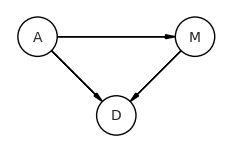

In [22]:
dag5_1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

Above DAG clearly shows that A impacts D directly and indirectly (i.e. via M)

The author used "total influence". What is meant by *total* is that we need to account for every path from **A** to **D**.

**MEDIATION** - Let's say that **A** did not directly influence **D**; rather it did it via **M**. This type of relationship is called *Mediation*


Author raises many interesting questions here. He asks if there is indeed a direct effect of marriage rate or rather is age at marriage just driving both, creating a **spurious** correlation between marriage rate and divorce rate


### 5.1.2. Testable implications

##### 5.8

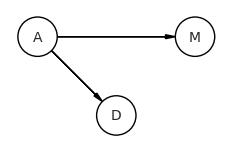

In [23]:
# Note - There is no explicit code section for drawing the second DAG
# but the figure appears in the book and hence drawing it as well
dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

We can get the joint probability distribution implied by our causal graphical model using

In [24]:
print(dag5_2.get_distribution())

P(A)P(M|A)P(D|A)


To see the Conditional Independencies, we can use one of the following two snippets. The explanation is that **M** and **D** are not independent, unless we condition on **A** when they become conditionally independent.

In [25]:
dag5_2.get_all_independence_relationships()

[('D', 'M', {'A'})]

In [26]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('D', 'M', {'A'})


##### 5.9

Checking the independencies in the first DAG

In [27]:
DMA_dag1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

Executing above cell should not display anything as in the DAG1 (where all nodes are connected to each other) there are no conditional independencies.

**RETHINKING: CONTROL**
- Statistical control is not the same as experimental control.

### 5.1.3. Multipl regression notation

Strategy:
1. Identify the predictor variables you want in the linear model of the mean
2. For each predictor, make a parameter that will measure its conditional association with the outcome
3. Multiply the parameter by the variable and add that term to the linear model

Model that predictive D using both M and A:
$$D_{i} \sim \text{Normal}(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha + \beta_{M}M_{i} + \beta_{A}A_{i}$$
$$\alpha \sim \text{Normal}(0, 0.2)$$
$$\beta_{M} \sim \text{Normal}(0, 0.5)$$
$$\beta_{A} \sim \text{Normal}(0, 0.5)$$
$$\sigma \sim \text{Exponential}(1)$$

The mechanial meaning is **the sum of three independent terms** -> this doesn't map onto a unique causal meaning. So?

Compact nottion and the design matrix

$$\mu_{i} = \alpha + \sum_{j=1}^{n}\beta_{j}x_{ji}$$
- $j$: index over predictor
- $n$: no. of predictors

This can be written more compatcly:
$$\pmb{m = Xb}$$
- $\pmb{m}$: a vector of predicted means
- $\pmb{b}$: a column vector of parameters
- $\pmb{X}$: a **design matrix**
    - Extra first column, filled with 1s (because the first parameter is the intercept)

### 5.1.3. Approximating the posterior

##### 5.10

In [28]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"] + bA * data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


In [29]:
az.summary(m_5_3_trace, var_names=["a", "bM", "bA", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.004,0.104,-0.199,0.191,0.003,0.002,1578.0,1247.0,1.0
bM,-0.062,0.160,-0.371,0.234,0.004,0.003,1410.0,1286.0,1.0
bA,-0.606,0.162,-0.912,-0.305,0.005,0.003,1280.0,1232.0,1.0
sigma,0.827,0.088,0.654,0.986,0.002,0.002,1365.0,1079.0,1.0


##### 5.11

`az.plot_forest` seems to be a super convenient tool to compare multiple models!

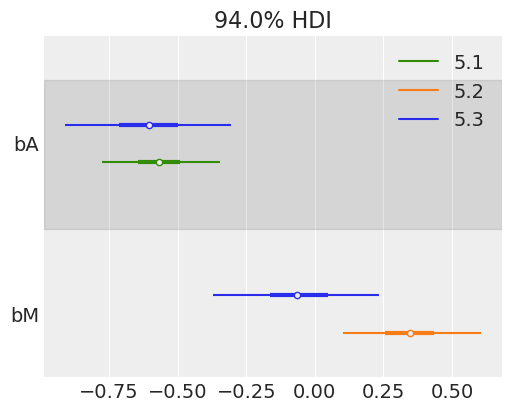

In [30]:
az.plot_forest(
    [
        m_5_3_trace,
        m_5_2_trace,
        m_5_1_trace,
    ],
    model_names=["5.3", "5.2", "5.1"],
    var_names=["bA", "bM"],
    combined=True,
    figsize=(5, 4)
);

`bA` rarely moves in 5.3 but `bM` is now near zero. So `bM` (marriag rate) is only associated w/ divorce when age at marriage is missing from the model.

**Model interpretation: once we know median age of marriage, there's little or no additional predictive power in also knowing the rage of marriage.**

This result implcates the **second DAG** (no connection between D & M), thus **the first DAG is out**.

M is predictive but **not causal**.

##### 5.12

In [31]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

### 5.1.5 Plotting multivariate posteriors

For multivariate regression, we need more plots to visualize model's inference. Three examples of interpretive plots:
1. **Predictor residual plots**: outcome vs. residual predictor values. Useful for understanding the statistical model but not much else.
2. **Posterior prediction plots**: model-based predictions vs. raw data (or display the error in prediction). Useful to check fit and assessing predictions. Not causal tools.
3. **Counterfactual plots**: Show the implied predictions for imaginary experiments. Useful to explore **causal implications** of manipulating one or more variables.

#### 5.1.5.1. Predictor residual plots

- Predictor residual = average prediction error when we use all of the other predictor varialbes to model a predictor of interest
- Benefit: once plotted against the outcome, we have a bivariate regression that's already conditions on all of the other predictor variables (= **it leaves the variation not expected by the model of the mean $\mu$ as a function of the other predictors**)
- How: we need other predictors to model predictor residuals.

Example; modeling **marriage rate (M)**:
$$M_{i} \sim \text{Normal}(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha + \beta_{A}A_{i}$$
$$\alpha \sim \text{Normal}(0, 0.2)$$
$$\beta_{A} \sim \text{Normal}(0, 0.5)$$
$$\sigma \sim \text{Exponential}(1)$$

So compared to the previous multiple regression model, now we're predicting M from a linear model that uses other predictor (in this case A).

##### 5.13

In [32]:
with pm.Model() as m_5_4:
    a = pm.Normal("a", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bAM * data["MedianAgeMarriage_std"])

    marriage_std = pm.Normal(
        "Marriage_std", mu=mu, sigma=sigma, observed=data["Marriage_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAM, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


**Computing residual: We need to subtract the observed marriage rate from the predicted values**

##### 5.14

In [33]:
mu_m_5_4_mean = m_5_4_trace["mu"].mean(axis=0)
residuals = data["Marriage_std"] - mu_m_5_4_mean

The meaning of residual signs:
- Positive residual: the observed marriage rate is excess of what the model expects
    - i.e., States w/ positive residuals have high marriage rates for their median age of marriage
- Negative residual: the observed marriage rate is below what the model expects
    - i.e., States w/ positive residuals have lower marriage rates for their median age of marriage

**This helps plot the relationship between these two variables and show the residuals as well.**

How to interpret Figure 5.4
- We can plot residuals (x, let's say marriage rate) vs. the outcome (divorce rate).
- Meaning: **the linear relationship between divorce and marriage rates, *having conditioned already on median age of marriage***
- Veritcal line at residual = 0: marriage rate exactly matches the expectations from median age at marriage
- States to the right of the line: higher marriage rates than expected.
- Average divorce rate on both sides of the vertical line is similar, meaning **little relationship between divorce and marraige rates**.

Same plot in Fig. 5.4. but now age residuals vs. divorce rate
- States to the right of the vertical line at 0 residual have older-than-expected median age at marriage
- The average divorce rate on the right side of the vertical line is *lower* than the rate on the left -> states where people marry older than expected for a given rate of marriage tend to have less divorce.

**What's the point of all of this?**
- Seeing the model-based predictions displayed against the outcome **after subtracting out the influence of other predictors**
- Linear models do all of this simultaneous measurement w/ a very specific additive model.
- **But predictor variables can be related to one another in non-additive ways**. -> In which case, the residual plots are not useful any more, but there are other ways to understand a model.

**RETHINKING: Residuals are parameters, not data**
- Regresiong x on y and then use x residuals as data in another model is WRONG!
- The right thing to do is to include x and y in the same model!

#### 5.1.5.2. Posterior prediction plots

They answer these questions:
1. **Did the model correctly approximate the posterior distribution?**
2. **How does the model fail?** This process is creative and relies on the analyst's domain expertise (risk of chasing noise exists though)

##### 5.15

Here we're reusing the `m_5_3` model.

In [34]:
# We can skip most of the code with the posterior predictive plot functionality in pymc3
with m_5_3:
    m_5_3_ppc = pm.sample_posterior_predictive(
        m_5_3_trace, var_names=["mu", "divorce_rate_std"], samples=1000
    )


mu_mean = m_5_3_ppc["mu"].mean(axis=0)
mu_hpd = az.hdi(m_5_3_ppc["mu"], 0.89)

D_sim = m_5_3_ppc["divorce_rate_std"].mean(axis=0)
D_PI = az.hdi(m_5_3_ppc["divorce_rate_std"], 0.89)

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


##### 5.16
Plotting observed vs. predicted

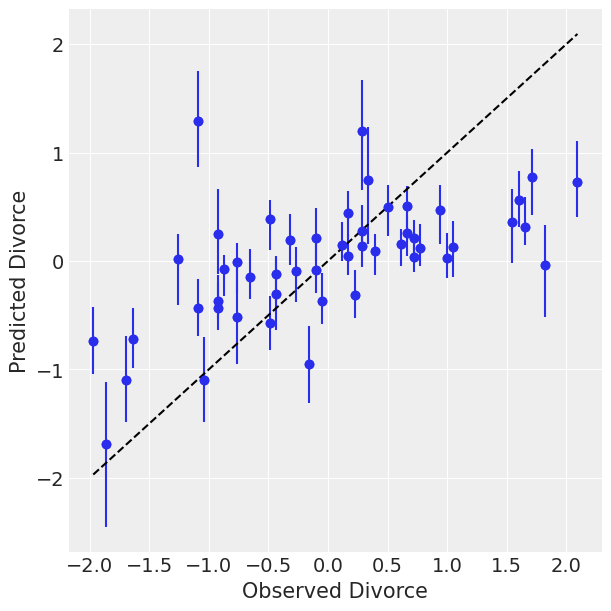

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    data["Divorce_std"].values,
    m_5_3_ppc["divorce_rate_std"].mean(0),
    yerr=np.abs(m_5_3_ppc["divorce_rate_std"].mean(0) - mu_hpd.T),
    fmt="C0o",
)
ax.scatter(data["Divorce_std"].values, D_sim)

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");

##### 5.18

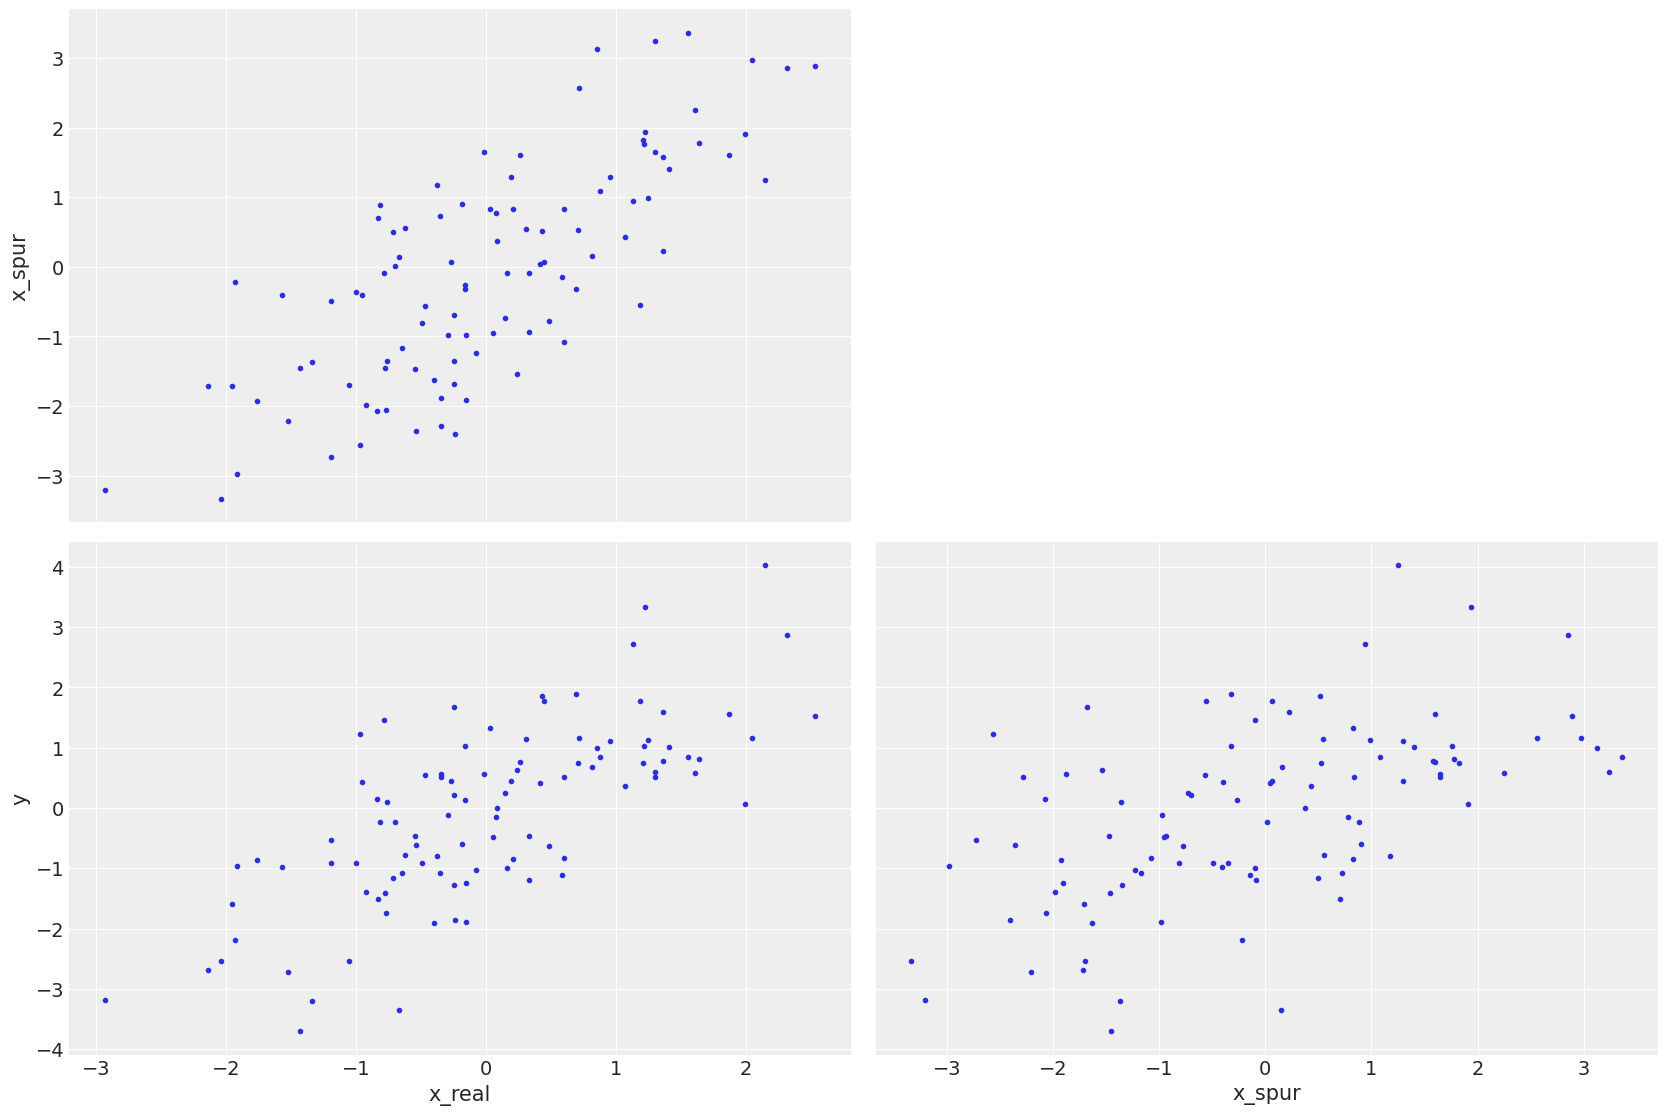

In [36]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

az.plot_pair({"x_real": x_real, "x_spur": x_spur, "y": y});

#### 5.1.5.3. Counterfactual plots
- Gemerate predoctions for imaginary interventions 
- Compute how much some observed outcome coulte be attributed to some cause

Caustion: *counterfactual* is an overloaded term.

**Recipe**
1. pick a variable to manipulate, the intervention variable.
2. Define the range of values to set the intervention variable to.
3. For each value of the intervention variable, and for each sample in posterior, use the causal model to simulate the values of other variables, including the outcome.

This gives you **a posterior distribution of counterfactual outcomes**.

The current DAG: A -> D <- M, and A -> M
- To implement A -> M, we need to regress A on M.

##### 5.19

In [37]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

# Use Theano shared variables so we can change them later
marriage_shared = shared(data["Marriage_std"].values)
age_shared = shared(data["MedianAgeMarriage_std"].values)

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"])

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"])

    m5_3_A_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [aM, bAM, sigma_m, a, bM, bA, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


##### 5.20

Remember that we've standardized the data.

In [38]:
# We're setting this to 50 to match the shape of our input
A_seq = np.linspace(-2, 2, 50)
A_seq.shape

(50,)

How is it different from actual data?

In [44]:
standardize(data['MedianAgeMarriage']).describe()

count    5.000000e+01
mean     3.885781e-15
std      1.000000e+00
min     -2.294894e+00
25%     -5.861871e-01
50%     -1.238310e-01
75%      5.596519e-01
max      2.931739e+00
Name: MedianAgeMarriage, dtype: float64

The range `A_seq` is within the data range.

##### 5.21

With `theano`'s shared variable, we can change the variable in the model and sample posterior predictions later from the model. This is convenient.

This way, we can easily plot.

In [39]:
# With PyMC3 we have to simulate in each model separately

# Simulate the marriage rates at each age first
age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace)

##### 5.22

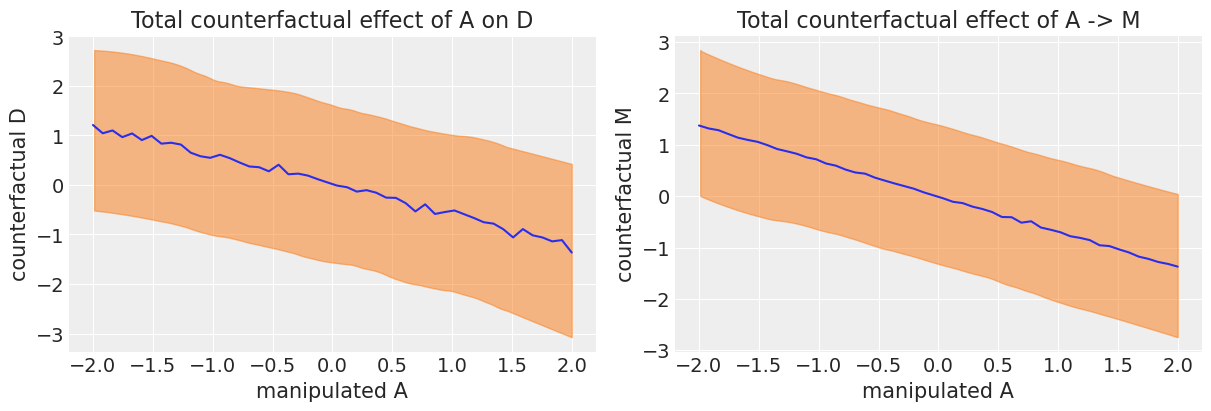

In [40]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(A_seq, m5_3_M_marriage["divorce"], ax=ax[0])
ax[0].plot(A_seq, m5_3_M_marriage["divorce"].mean(0))
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


az.plot_hdi(A_seq, m5_3_M_marriage["marriage"], ax=ax[1])
ax[1].plot(A_seq, m5_3_M_marriage["marriage"].mean(0))
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

Our DAG has A -> D & A -> M -> D. It seems A -> M effect is similar to the total effect of A -> D. So we can assume that M -> D itself is weak.

##### 5.23

Expected causal effect of increasing median age from 20 to 30:

In [45]:
# We're setting this to 50 to match the shape of our input
A_seq = (np.linspace(20, 30, 50) - 26.1) / 1.24

age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

# Average first and last column and take difference
m5_3_M_ppc["divorce"][:, -1].mean() - m5_3_M_ppc["divorce"][:, 0].mean()

-5.022473066622904

In [51]:
A_seq.min(), A_seq.max()

(-4.919354838709679, 3.1451612903225796)

The trick w/ simulating counterfactuals (=**intervention**)
- realize that when we manipulate some variable X, we break the causal influence of other variables on X
- Same as saying we modify the DAG so that no arrows enter X

A -> D <- M only. No arrow from A -> M because **we control the values of M** directly (=as if it's a perfectly controlled experiment).

**This can be done through `shared`**.
- Shared variables allow us to set the values directly throuhg `set_value(new_value)`
- Below, we are setting `A = 0` to remove the effect of age.
- Note that **we didn't change the model `m5_3_A` at all.**

<font color='red'>This is the beauty of the causal analysis. Once we have the model, we can manipulate and simulate interventions.</font>

##### 5.24

In [52]:
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_shared.set_value(marriage_counter_factual_x)

# Fix age to zero
age_shared.set_value(np.zeros(50))

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

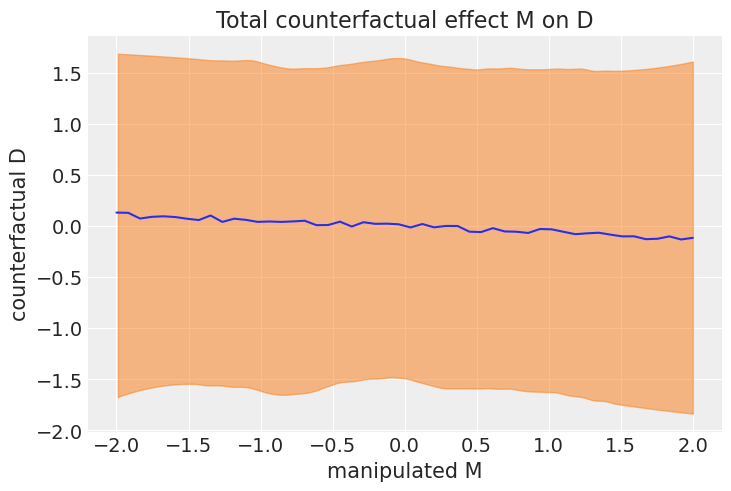

In [53]:
fig, ax = plt.subplots()

az.plot_hdi(marriage_counter_factual_x, m5_3_M_ppc["divorce"], ax=ax)
ax.plot(marriage_counter_factual_x, m5_3_M_ppc["divorce"].mean(0))
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");

##### 5.25

In [54]:
A_seq = np.linspace(-2, 2, 30)

##### 5.26

In [55]:
# Get the samples from Age Marriage model first
with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma_m", "aM", "bAM"], samples=1000
    )

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [57]:
marriage_mu_counterfactual = np.outer(m5_3_M_marriage["aM"] + m5_3_M_marriage["bAM"], A_seq)
marriage_mu_counterfactual.shape

(1000, 30)

In [58]:
M_sim = stats.norm(loc=marriage_mu_counterfactual.T, scale=m5_3_M_marriage["sigma_m"]).rvs()
M_sim.shape

(30, 1000)

##### 5.27

In [59]:
with m5_3_A:
    m5_3_M_divorce = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma", "bM", "bA", "a"], samples=1000
    )

In [60]:
D_sim = np.zeros((30, 1000))
a, bM, bA = m5_3_M_divorce["a"], m5_3_M_divorce["bM"], m5_3_M_divorce["bA"]

for i, age_counterfactual in enumerate(A_seq):
    divorce_mu_counterfactual = a + bA * age_counterfactual + bM * M_sim[i, :]
    samples = stats.norm(divorce_mu_counterfactual, m5_3_M_divorce["sigma"]).rvs()
    D_sim[i, :] = samples

## 5.2. Masked relationship

What happesn if we have two predictor variables that are correlated w/ one another (one is positively correlated w/ the outcome and the other is negatively correlated)?

The Milke dataset

##### 5.28

In [61]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [62]:
d.shape

(29, 8)

Popular hypothesis: **primates w/ larger brains produce more energetic milk, so that brains grow quickly**.
- Question: **To what extent energy content of milk (`kcal.per.g`) is related to the percent of the neocortex mass.**
- Why we need female body mass: to see the masking that hides the relationships among the variables.

##### 5.29

In [63]:
d["K"] = standardize(d["kcal.per.g"]) # milk nutrition
d["N"] = standardize(d["neocortex.perc"]) # compared to total body mass
d["M"] = standardize(d["mass"]) # average female body mass

The first model (simple bivariate regression with `kcal.per.g` and `neocortex.perc`):

$$K_{i} \sim \text{Normal}(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha + \beta_{N}N_{i}$$

K: standardized kcal
N: standardized neocortex percent

##### 5.30

In [64]:
# This is meant to fail!
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * d["N"])

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    m5_5_draft_trace = pm.sample()

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'sigma_log__': array(-0.36651292), 'bN': array(0.), 'a': array(0.)}

Initial evaluation results:
sigma_log__   -1.06
bN            -0.92
a             -0.92
K               NaN
Name: Log-probability of test_point, dtype: float64

This error happens because there are missing values in the data.

##### 5.32

In [66]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

##### 5.32

In [67]:
dcc = d.dropna(axis=0)
dcc.shape

(17, 11)

We just dropped all rows that have any missing values -> **Complete Case Analysis**.
- Obviously this isn't always a goodt hing.
- The validity depends on the process that caused these particular values to go missing.

##### 5.33

In [68]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


Considering the priors: "are these priors **reasonable**?" -> To answer this questions, we can simulate **prior predictive distribution**.

##### 5.34

Why does `xseq` have only two values?
- This is essentially the start and end point of a line.

In [88]:
xseq = [-2, 2] # standardized
shared_N.set_value(np.array(xseq))

# shared_N.set_value(np.linspace(-2, 2, 50)) -> this doesn't work.

with m5_5_draft:
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()

In [89]:
m5_5_draft_prior_predictive['K'].shape

(500, 2)

In [90]:
m5_5_draft_prior_predictive["K"][i].shape

(2,)

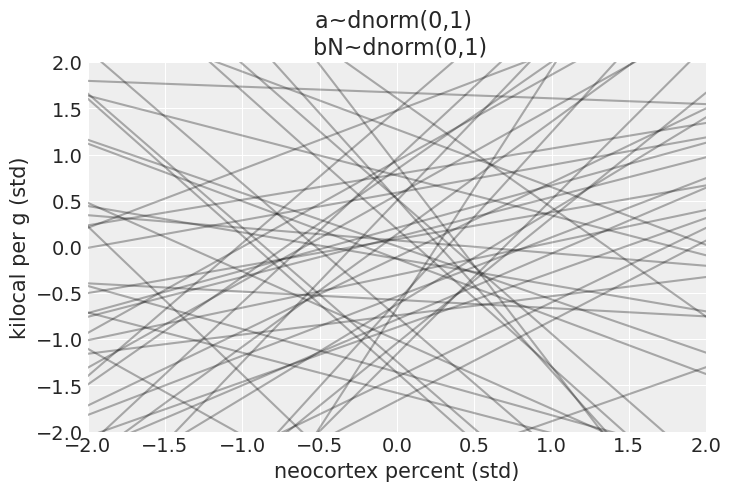

In [91]:
fig, ax = plt.subplots()

for i in range(50):
    ax.plot(xseq, m5_5_draft_prior_predictive["K"][i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

These lines are crazy! Thus, we can try to make this relationship tighter 
- By tightening the alpha prior so that it sticks closer to zero. (**reduce the sigma**)
    - With two standardized variables, when predictor = 0, the expected value of the outcome should also be 0.
- The slope $\beta_{N}$ should also be a bit tighter so that it doesn't regularly produce impossibly strong relationships. (**reduce the sigma**)

##### 5.35

In [118]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_trace = pm.sample(tune=2000, draws=10000)

m5_5_data = az.from_pymc3(m5_5_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 16 seconds.


##### 5.36

In [119]:
az.summary(m5_5_trace, var_names=["a", "bN", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.035,0.160,-0.267,0.333,0.001,0.001,25331.0,14525.0,1.0
bN,0.126,0.246,-0.330,0.589,0.002,0.002,22777.0,14381.0,1.0
sigma,1.112,0.206,0.762,1.495,0.001,0.001,21323.0,13922.0,1.0


This is neither strong nore very precise association. **How do we know?** (better to draw the picture)

From this point, it looks like we are using the *counterfactual* plot a lot.

##### 5.37

<font color='red'>Process</font>

1. Determine which value to manipulate (`N`)
2. Define the range (`xseq`)
3. Set the shared w/ new value (`shared.set_value(xseq)`)
4. Sample the posterior predictions from the model
5. Plot

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


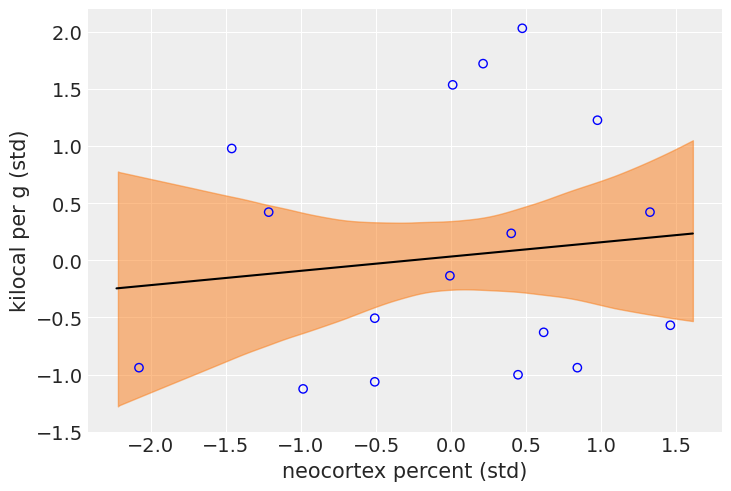

In [120]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 30)

shared_N.set_value(xseq)

with m5_5:
    m5_5_posterior_predictive = pm.sample_posterior_predictive(
        m5_5_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_5_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
az.plot_hdi(xseq, m5_5_posterior_predictive["mu"], ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

Interpretation
- This posterior mean line is weakly positive.
- Also highly imprecise; **A lot of positive and negative slopes are plausible.**

**Thus, we'll consider another predictor variable**; adult female body mass.
- **Logarithm** of body mass: **why?** It's often true that scaling measurements like body mass are relatedrelated by **magnitudes** to other variables. Taking the log of a measure translates the measure into magnitudes.** 

##### 5.38

This time, we remove neocortex but just add body mass.

In [121]:
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_6:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6_trace = pm.sample(tune=2000, draws=10000)

m5_6_data = az.from_pymc3(m5_6_trace) # Convert pymc3 data into an InferenceData object.
az.summary(m5_6_trace, var_names=["bM", "a", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, sigma]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.305,0.244,-0.750,0.164,0.002,0.001,23164.0,14580.0,1.0
a,0.046,0.160,-0.251,0.347,0.001,0.001,20059.0,13849.0,1.0
sigma,1.058,0.197,0.721,1.430,0.001,0.001,19232.0,11908.0,1.0


$\uparrow$ Log mass is negatively associated w/ energy

##### 5.39

Now adding both terms

In [122]:
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_7:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = pm.Deterministic("mu", a + bN * shared_N + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_7_trace = pm.sample(tune=2000, draws=10000)

m5_7_data = az.from_pymc3(m5_7_trace)
az.summary(m5_7_trace, var_names=["a", "bN", "bM", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, bN, sigma]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 16 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.060,0.152,-0.229,0.344,0.001,0.001,19231.0,14207.0,1.0
bN,0.381,0.257,-0.095,0.863,0.002,0.002,13267.0,13881.0,1.0
bM,-0.513,0.266,-1.006,-0.004,0.002,0.002,12998.0,13143.0,1.0
sigma,0.969,0.192,0.649,1.331,0.002,0.001,12136.0,11156.0,1.0


In [112]:
m5_7

##### 5.40

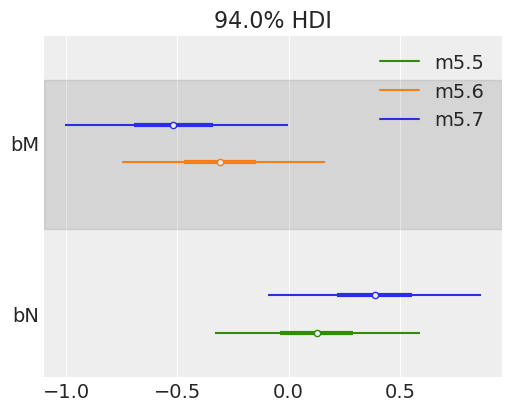

In [125]:
az.plot_forest(
    [m5_7_data, m5_6_data, m5_5_data],
    model_names=["m5.7", "m5.6", "m5.5"],
    var_names=["bM", "bN"],
    combined=True, 
    figsize=(5, 4)
);

You can clearly see that one is positively correlated and the other is not. (m5.7)

Three possibilities:

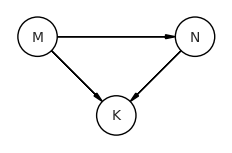

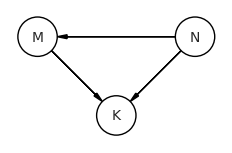

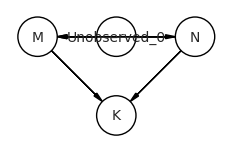

In [159]:
models = [CausalGraphicalModel(nodes=["M", "N", "K"], edges=[("M", "K"), ("M", "N"), ("N", "K")]),
          CausalGraphicalModel(nodes=["M", "N", "K"], edges=[("M", "K"), ("N", "M"), ("N", "K")]),
          CausalGraphicalModel(nodes=["M", "N", "K"], edges=[("M", "K"), ("N", "M"), ("N", "K")], latent_edges=[("M", "N")])]
for model in models:
    pgm = daft.PGM(); coordinates = {"M": (0, 0), "K": (1, 1), "N": (2, 0), 'Unobserved_0': (1, 0)}
    for node in model.dag.nodes:
        pgm.add_node(node, node, *coordinates[node])
    for edge in model.dag.edges:
        pgm.add_edge(*edge)
    pgm.render()
    plt.gca().invert_yaxis()

**Which of these graphs is right?**
- We can't tell from the data alone becuase they imply the same set of **conditional independencies** -> Is it?
    - In this case, "there are no conditional independencies" because they all imply that all pairs of variables are associated regardless of what we condition on.
    - **Markov equivalence set**: A set of DAGs with the same conditional independencies
- Why the data alone can't tell which model is correct, our **scientific knowledge of the variables** will eliminate a large number of silly, but Markov equivalent, DAGs.    

##### 5.41
(This code actually produces right plot Confirned from Professor McElreath that the book text is mistaken.)

Counterfactual plot:

Again, the process:
1. Choose a predictor I want to manipulate: M
2. Come up with a range: xseq
3. If I am only interested in this, set others to zero: N
4. Posterior predictive sampling from the model (need trace, variable name (what's on the y axis))
5. Plot the mean and hdi together

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


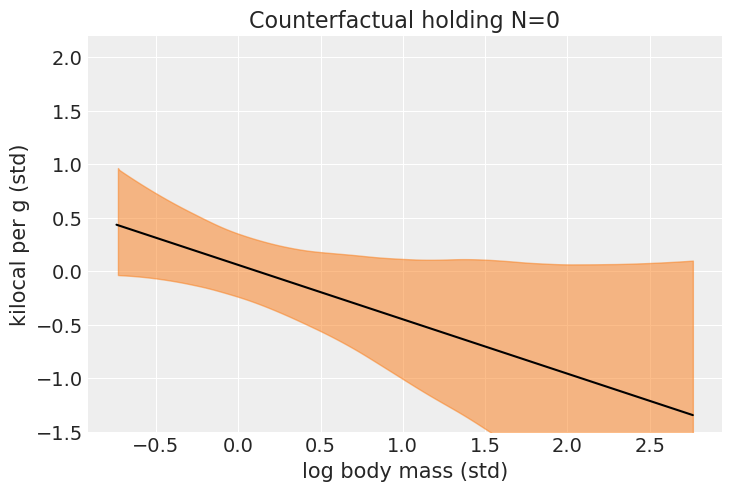

In [160]:
xseq = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 30)
shared_N.set_value(np.zeros(30))
shared_M.set_value(xseq)

with m5_7:
    m5_7_posterior_predictive = pm.sample_posterior_predictive(
        m5_7_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_7_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
az.plot_hdi(xseq, m5_7_posterior_predictive["mu"], ax=ax)
ax.plot(xseq, mu_mean, c="black")

ax.set_ylim(-1.5, 2.2)
ax.set_title("Counterfactual holding N=0")
ax.set_ylabel("kilocal per g (std)")
ax.set_xlabel("log body mass (std)");

**OVERTHINKING: Simulating a masking relationship**

##### 5.42

In [161]:
# M -> K <- N
# M -> N

n = 100
M = stats.norm().rvs(n)
N = stats.norm(M).rvs(n)
K = stats.norm(N - M).rvs(n)
d_sim = pd.DataFrame({"K": K, "M": M, "N": N})

##### 5.43

In [162]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim2 = pd.DataFrame({"K": K, "M": M, "N": N})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim3 = pd.DataFrame({"K": K, "M": M, "N": N})

## 5.3. Categorical variables

These are also called as *factors*.

**RETHINKING: Continuous countries**
- DANGEROUS

### 5.3.1. Binary categories

##### 5.45
The height dataset

**Approach 1**: **indicator** variable (=dummy variable)

In [163]:
d = pd.read_csv(os.path.join("Data", "Howell1.csv"), delimiter=";")
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


**The impact of using the dummy variable**
- $\alpha$ (intercept) becomes the average female height.
- This can make assigning sensible priors a little harder.
- For now, we can **get away with a vague prior because we have a lot of data.**

##### 5.46

In [64]:
mu_female = stats.norm(178, 20).rvs(1000)
mu_male = stats.norm(178, 20).rvs(1000) + stats.norm(0, 10).rvs(1000)

az.summary({"mu_female": mu_female, "mu_male": mu_male}, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu_female,177.507,19.966,141.090,215.392
mu_male,178.203,21.419,139.391,220.222


**Approach 2: Index variable**
- Integers that correspond to different categories (1: female, 2: male)

$$h_{i} \sim \text{Normal}(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha_{SEX[i]}$$
$$\alpha_{j} \sim \text{Normal}(178, 20) \text{ for } j=1..2$$
$$\sigma \sim \text{Uniform}(0, 50)$$

This creates a list of $\alpha$ parameters, one for each unique value in the index variable.
- This is shown in the below as `shape=2` when we define the distribution of `mu`.

**Main benefit: it solves the problem of priors!**
- The same prior can be assigned to each, corresponding to the notion that *all the categories are the same*, prior to the data.
- Neither category has more prior uncertainty than the other.
- This approach extends to more than 2 categories.

##### 5.47

In [165]:
sex = d["male"].values

with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"])
    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.878,1.647,131.893,138.198,0.031,0.022,2771.0,1284.0,1.0
mu[1],142.636,1.689,139.595,146.000,0.032,0.023,2728.0,1635.0,1.0
sigma,27.404,0.818,25.970,29.019,0.016,0.011,2602.0,1417.0,1.0


##### 5.48 and 5.59

Posterior sampling and computing the **expected difference between females and males** (`diff`)

In [167]:
# With PyMC3 it's easier just to create a deterministic that includes both values
sex = d["male"].values

with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"])
    diff_fm = pm.Deterministic("diff", mu[0] - mu[1])
    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.910,1.611,131.951,138.022,0.031,0.022,2760.0,1542.0,1.0
mu[1],142.630,1.717,139.263,145.637,0.033,0.024,2676.0,1532.0,1.0
sigma,27.387,0.842,25.827,28.889,0.017,0.012,2542.0,1473.0,1.0
diff,-7.721,2.369,-11.970,-3.096,0.042,0.034,3137.0,1395.0,1.0


This diff is called **contrast**.

### 5.3.2. Many categories

**With more than 2 categories, the indicator approach explodes. Thus, we will stick to index indicator approach.**

##### 5.50

In [168]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


##### 5.51
including `clade`: taxonomic memebership of each species (categorical)
- We're using pandas to convert categories into indices.

In [169]:
print(d["clade"].unique())

['Strepsirrhine' 'New World Monkey' 'Old World Monkey' 'Ape']


In [170]:
d["clade_id"] = pd.Categorical(d["clade"]).codes
print(d["clade_id"].unique())

[3 1 2 0]


##### 5.52
Notes on the model `m5_9`
- K is standardized.
- Widedned the prior $\alpha$ to allow the different clades to disperse (if the data wants them to)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


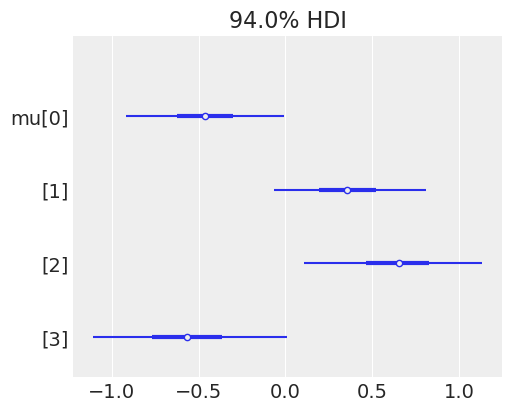

In [171]:
d["K"] = standardize(d["kcal.per.g"])

with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    # shape = max + 1 because of the zero indexing
    # mu's sigma is smaller now (wider)
    mu = pm.Normal("mu", 0, 0.5, shape=d["clade_id"].max() + 1) 
    K = pm.Normal("K", mu[d["clade_id"]], sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.plot_forest(m5_9_trace, combined=True, var_names=["mu"], figsize=(5, 4));

We can also easily add another categorical variable to the model.

##### 5.53

In [173]:
d["house"] = np.random.randint(0, 4, size=d.shape[0])

##### 5.54

In [174]:
with pm.Model() as m5_10:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", 0, 0.5, shape=d["house"].max() + 1)
    mu_clade = pm.Normal("mu_clade", 0, 0.5, shape=d["clade_id"].max() + 1)
    mu = mu_clade[d["clade_id"].values] + mu_house[d["house"].values]

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.summary(m5_9_trace, var_names=["mu_clade", "mu_house"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_clade, mu_house, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_clade[0],-0.461,0.290,-1.009,0.069,0.007,0.005,1649.0,1338.0,1.0
mu_clade[1],0.348,0.280,-0.172,0.859,0.007,0.005,1733.0,1746.0,1.0
mu_clade[2],0.618,0.316,-0.000,1.198,0.008,0.006,1649.0,1452.0,1.0
mu_clade[3],-0.516,0.337,-1.143,0.123,0.008,0.006,1850.0,1583.0,1.0
mu_house[0],0.074,0.313,-0.496,0.651,0.007,0.006,1745.0,1474.0,1.0
mu_house[1],-0.044,0.297,-0.589,0.510,0.007,0.005,1610.0,1784.0,1.0
mu_house[2],-0.154,0.289,-0.679,0.388,0.007,0.005,1619.0,1331.0,1.0
mu_house[3],0.145,0.310,-0.385,0.778,0.008,0.006,1583.0,1374.0,1.0


It's also possible to do forest plot for both categorical variables

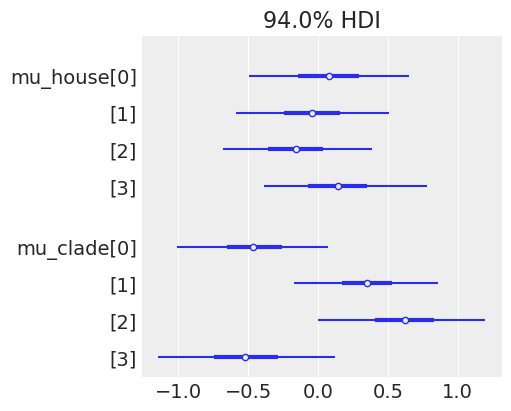

In [178]:
az.plot_forest(m5_9_trace, combined=True, var_names=["mu_house", "mu_clade"], figsize=(5, 4));

**RETHINKING: Differences and statistical significance**
- Addressing the difference SHOULD involve computing the difference **contrast**.
- Need to compute the posterior distribution of the difference in slopes.

## 5.4 Summary
- Multiple regression
- "What is the value of knowing each predictor, once we already know the other predictors?"
- The answer to this question does not by itself provide any causal information.
- Causal inference requires additional assumptions.
- DAG models of causation are one way to represent those assumptions.

In [72]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jan 17 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

pandas    : 1.2.0
scipy     : 1.6.0
pymc3     : 3.10.0
sys       : 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
numpy     : 1.19.4
daft      : 0.1.0
arviz     : 0.10.0
matplotlib: 3.3.3

Watermark: 2.1.0

